# abc without hm

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import chi2

### credible interval analysis 

# Component-wise Confidence Intervals

class ciana:
    def __init__(self, data:np.array,keyword:str, alpha=0.95, critical_val=1.96):
        super().__init__()
        self.data = data # ensure the data is a 2-dim array
        self.alpha = alpha
        self.critical_val = critical_val
        self.keyword = keyword

        # compute essential statistics 
        theta1_mean, theta2_mean = np.mean(self.data[:,0]), np.mean(self.data[:,1])
  
        self.theta1_mean = theta1_mean
        self.theta2_mean = theta2_mean

        self.n = self.data.shape[0]
        self.chi2_val = chi2.ppf(self.alpha, df=2)  # Degrees of freedom = 2 (for 2D)

        self.cov =  np.cov(self.data, rowvar=False)
        self.theta1_std = self.cov[0,0]
        self.theta2_std = self.cov[1,1]
        self.corr = self.cov[0,1]/(self.theta1_std  * self.theta2_std)
        
        # Eigenvalue Decomposition for Covariance Matrix
        # Decompose the covariance matrix to get the eigenvalues and eigenvectors, 
        # which define the shape and orientation of the confidence ellipse.
        # The eigenvalues represent the lengths of the ellipse axes, and the eigenvectors determine the orientation of the ellipse.

        eigvals, eigvecs = np.linalg.eigh(self.cov)
        self.eigvecs = eigvecs
        self.eigvals = eigvals

    def comp_wise_ci(self):
        """
        return: the ci interval for both meta and vision
        """
        ci_theta1 = np.array([self.theta1_mean - self.critical_val * self.theta1_std / np.sqrt( self.n),
                              self.theta1_mean + self.critical_val * self.theta1_std / np.sqrt( self.n) ])

        ci_theta2 = np.array([self.theta2_mean - self.critical_val * self.theta2_std / np.sqrt( self.n),
                              self.theta2_mean + self.critical_val * self.theta2_std / np.sqrt( self.n) ])
        return ci_theta1, ci_theta2
    
    def joint_confi_ellipsoid(self):
        
        # Step 5: Generate the ellipsoid
        theta = np.linspace(0, 2 * np.pi, 100)
        ellipse = np.array([np.cos(theta), np.sin(theta)])

        # Scale ellipse by sqrt(eigenvalues) and rotate by eigenvectors
        ellipsoid = np.dot(np.diag(np.sqrt(self.eigvals * self.chi2_val)), ellipse)
        ellipsoid = np.dot(self.eigvecs, ellipsoid)

        # Shift ellipsoid to the mean
        ellipsoid[0, :] += self.theta1_mean
        ellipsoid[1, :] += self.theta2_mean
        self.ellipsoid = ellipsoid

        # plot
        plt.figure(figsize=(8, 6))
        plt.scatter(self.data[:, 1], self.data[:, 0], alpha=0.5, label='Estimates')
        plt.plot(ellipsoid[1, :], ellipsoid[0, :], color='red', label='95% Confidence Ellipse')
        plt.scatter(y=self.theta1_mean, x=self.theta2_mean, color='red', label='Mean')
        plt.xticks(range(0,11,1))
        plt.yticks(range(0,5,1))
        plt.xlabel('Max vision')
        plt.ylabel('Max metabolism')
        plt.title(f'Joint Confidence Region (Ellipsoid) for {self.keyword}')
        plt.legend()
        plt.grid(True)
        # plt.axis('equal')
        plt.show()

# ciana1

In [5]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def ciana1(data, keyword): # to generate the ellipsoid for SMC gaussian kernel

    # Parameters for the multivariate normal distribution
    mean = np.mean(data, axis=0).tolist() # Mean of the distribution
    covariance = np.cov(data, rowvar=False) #Covariance matrix
    y, x = np.mgrid[1:11:.1, 1:5:.1] # Grid for plotting
    pos = np.dstack((x, y)) # Combine the grid into a single array

    # Compute the multivariate normal distribution
    rv = multivariate_normal(mean, covariance)
    pdf = rv.pdf(pos) # Probability density function

    # Plot the posterior distribution (ellipsoid shape)
    plt.figure(figsize=(10, 8))
    plt.contourf(y, x, pdf, levels=50, cmap='viridis', alpha=0.6)
    plt.colorbar(label='Density')
    plt.xlabel('max vision')
    plt.ylabel('max metabolism')
    plt.xlim((1,10))
    plt.ylim((1,4))
    plt.title(f'Joint Confidence Region (Ellipsoid) for {keyword}')

    # Marginal distributions
    # Y marginal (integrating out X), mean[0] is the mean of meta we put on the y axis
    y_marginal = np.linspace(1, 4, 100)
    y_pdf = multivariate_normal(mean[0], covariance[0][0]).pdf(y_marginal)
    # y_pdf = y_pdf / y_pdf.sum()

    # X marginal (integrating out Y)
    x_marginal = np.linspace(1, 10, 100)
    x_pdf = multivariate_normal(mean[1], covariance[1][1]).pdf(x_marginal)
    # x_pdf = x_pdf / x_pdf.sum()
    
    # Plotting the marginal distributions
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(x_marginal, x_pdf, color='blue')
    plt.title('Marginal Distribution of max vision')
    plt.xlabel('max_vision')
    plt.ylabel('Density')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(y_marginal, y_pdf, color='orange')
    plt.title('Marginal Distribution of max metabolism')
    plt.xlabel('max_metabolism')
    plt.ylabel('Density')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [6]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, gaussian_kde

def ciana2(data, keyword): # to generate the ellipsoid for SMC uniform kernel
    
    marginal_theta1, marginal_theta2 = data[:,0], data[:,1]

    # Calculate mean and covariance
    mean = np.mean(data, axis=0)
    cov = np.cov(data, rowvar=False)

    # Eigenvalue decomposition for ellipsoid
    eigvals, eigvecs = np.linalg.eigh(cov)

    # Generate the ellipsoid
    phi = np.linspace(0, 2 * np.pi, 100)
    ellipsoid = np.array([np.cos(phi), np.sin(phi)])

    # Scale the ellipsoid by the square roots of the eigenvalues
    ellipsoid = np.dot(np.diag(np.sqrt(eigvals)), ellipsoid)

    # Rotate and shift the ellipsoid
    ellipsoid = np.dot(eigvecs, ellipsoid)
    ellipsoid[0, :] += mean[0]
    ellipsoid[1, :] += mean[1]

    # Plotting
    plt.figure(figsize=(10, 8))
    plt.scatter(y=data[:, 0], x=data[:, 1], alpha=0.5, label='Accepted Samples', color='blue')
    plt.plot(ellipsoid[1, :], ellipsoid[0, :], color='red', label='Ellipsoid')
    plt.title(f'Uniform Kernel SMC ABC with Ellipsoid {keyword}')
    plt.xlabel('Max vision')
    plt.ylabel('Max metabolism')
    plt.xlim(1,10)
    plt.ylim(1,4)
    plt.axhline(0, color='k', lw=0.5)
    plt.axvline(0, color='k', lw=0.5)
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()
        
    
    # Plotting the marginal distributions
    plt.figure(figsize=(12, 5))
    
    # Marginal distribution of theta1
    plt.subplot(1, 2, 1)
    plt.hist(marginal_theta1, bins=30, density=True, alpha=0.5, color='blue', label='Histogram')
    kde_theta1 = gaussian_kde(marginal_theta1)
    x_theta1 = np.linspace(0, 10, 100)
    plt.plot(x_theta1, kde_theta1(x_theta1), color='red', label='KDE')
    plt.title('Marginal Distribution of Max metabolism')
    plt.xlabel('max metabolism')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)

    # Marginal distribution of theta2
    plt.subplot(1, 2, 2)
    plt.hist(marginal_theta2, bins=30, density=True, alpha=0.5, color='green', label='Histogram')
    kde_theta2 = gaussian_kde(marginal_theta2)
    x_theta2 = np.linspace(0, 5, 100)
    plt.plot(x_theta2, kde_theta2(x_theta2), color='orange', label='KDE')
    plt.title('Marginal Distribution of Max vision')
    plt.xlabel('max vision')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

### error converge


In [12]:
xticks = range(1,12,1)
yticks = range(1,6)

def plot_results(theta=None): # function used to plot the 2d histogram
    
    fig, axes = plt.subplots(1, 1, figsize=(9, 3))
    # are weight necessary?
    W = [1 for i in range(N)]
    X = [t[1] for t in theta]
    Y = [t[0] for t in theta]
    p = plt.hist2d(x=X, y=Y, weights=W, density=True,
                   bins=((xticks, yticks)), cmap='magma')
    plt.xlabel('max vision', fontsize=16)
    plt.ylabel('max metabolism', fontsize=14)
    plt.xticks([x+0.5 for x in xticks[:-1]], xticks[:-1], fontsize=12)
    plt.yticks([y+0.5 for y in yticks[:-1]], yticks[:-1], fontsize=12)
    plt.colorbar(p[3])
    fig.tight_layout()
    #plt.show()
    #plt.savefig('/abc_reject_results.pdf')

## abc base without hm

In [21]:
import numpy as np
import pandas as pd

abc_wout_history = np.load('E:/Imperial 2023-24/project!!/sugarscape/abc_without_hm/abc_base/other data/abc_reject_results_300_obs79_acceptance_threshold_10.npy',
                          allow_pickle=True)
abc_wout_history = np.array([r[0] for r in abc_wout_history]) # size = (300,2)
abc_wout_history_tuple = [(abc_wout_history[r][0], abc_wout_history[r][1]) for r in range(300)]
pd.Series(abc_wout_history_tuple).value_counts()
type(abc_wout_history_tuple)

list

Text(0.5, 1.0, '2D Histogram for ABC base with HM bot applied')

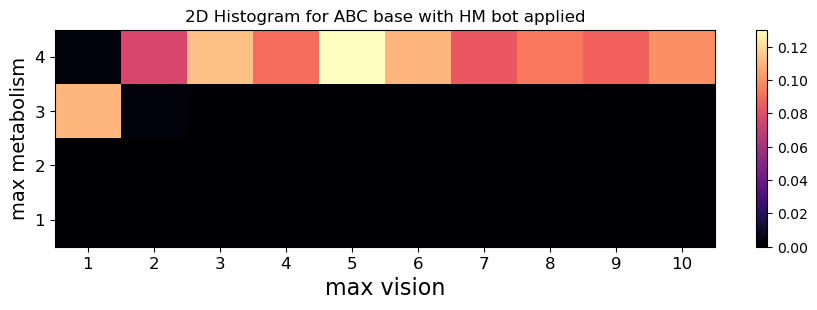

In [20]:
import matplotlib.pyplot as plt 
N =300
plot_results(abc_wout_history_tuple)
plt.title('2D Histogram for ABC base with HM bot applied')


The component wise CI for sa, without hm, is: 
 (array([3.87525725, 3.89807609]), array([4.47457985, 6.31208682]))
The joint ellipsoid CI for sa, without hm, is: 



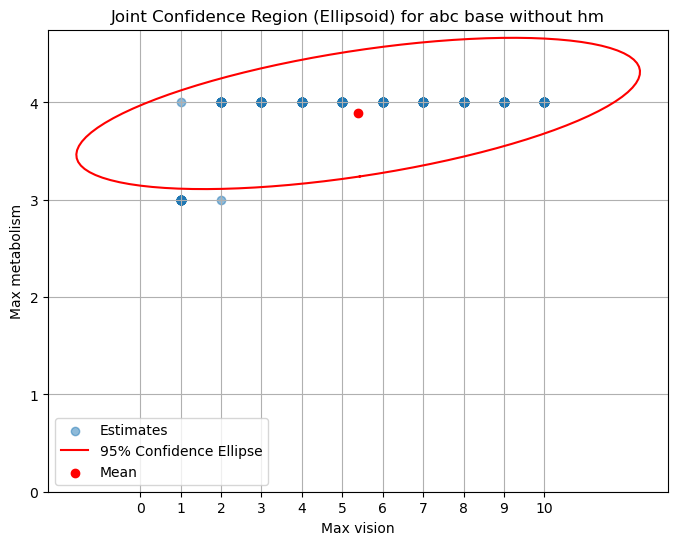

In [9]:
# ci analysis 
ci_ana = ciana(data=abc_wout_history, keyword='abc base without hm')

print('The component wise CI for sa, without hm, is: \n',ci_ana.comp_wise_ci())
print('The joint ellipsoid CI for sa, without hm, is: \n')
ci_ana.joint_confi_ellipsoid()


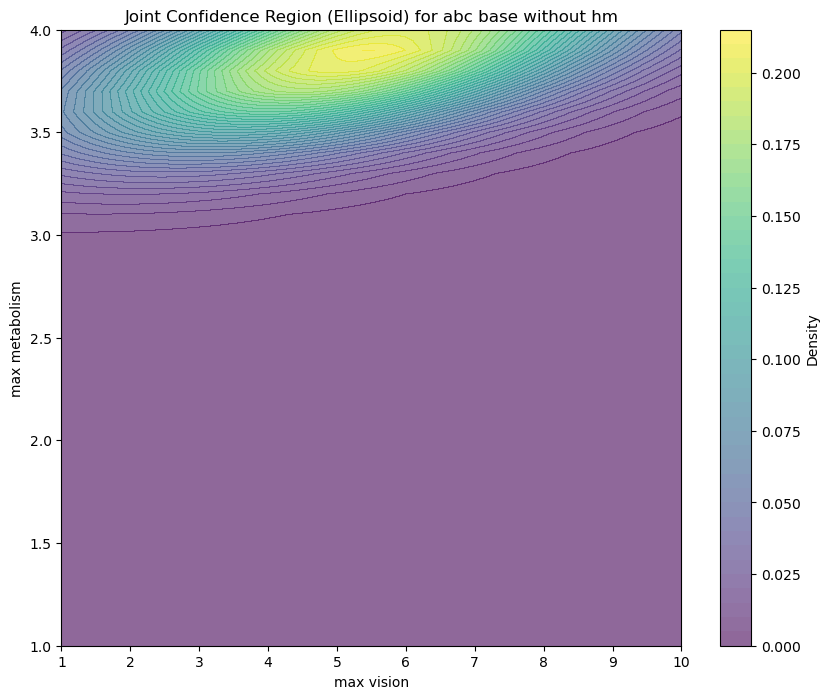

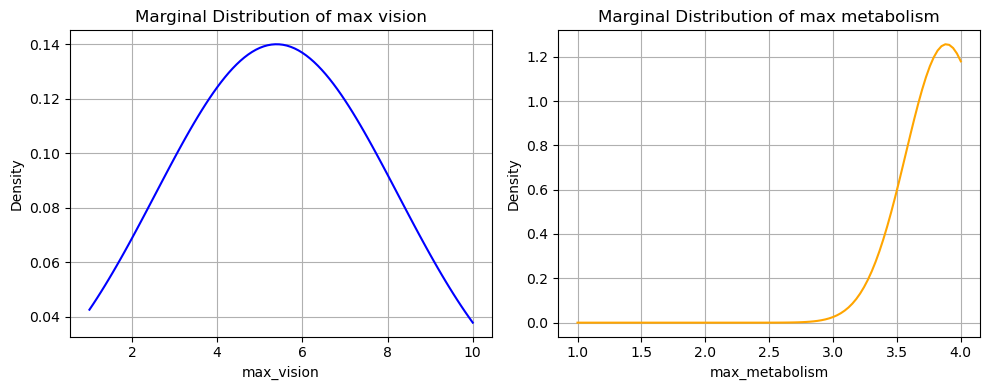

In [10]:
ciana1(data=abc_wout_history, keyword='abc base without hm')

In [23]:
import pickle

pmr_data = np.load('E:/Imperial 2023-24/project!!/sugarscape/pmr_without_abc.npy', allow_pickle=True)

The component wise CI for sa, without hm, is: 
 (array([3.99628946, 3.99704387]), array([5.91520855, 6.17812478]))
The joint ellipsoid CI for sa, without hm, is: 



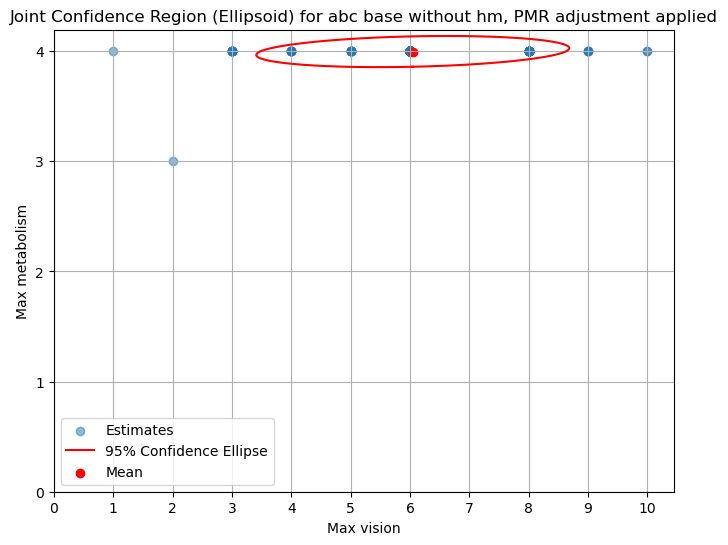

In [15]:
# ci analysis 
ci_ana = ciana(data=pmr_data, keyword='abc base without hm, PMR adjustment applied')

print('The component wise CI for sa, without hm, is: \n',ci_ana.comp_wise_ci())
print('The joint ellipsoid CI for sa, without hm, is: \n')
ci_ana.joint_confi_ellipsoid()


In [16]:
N= 300
plot_results(pmr_data)
plt.title('Histogram for ABC base calibration, without HM, after PMR adjustemnt')

NameError: name 'plot_results' is not defined

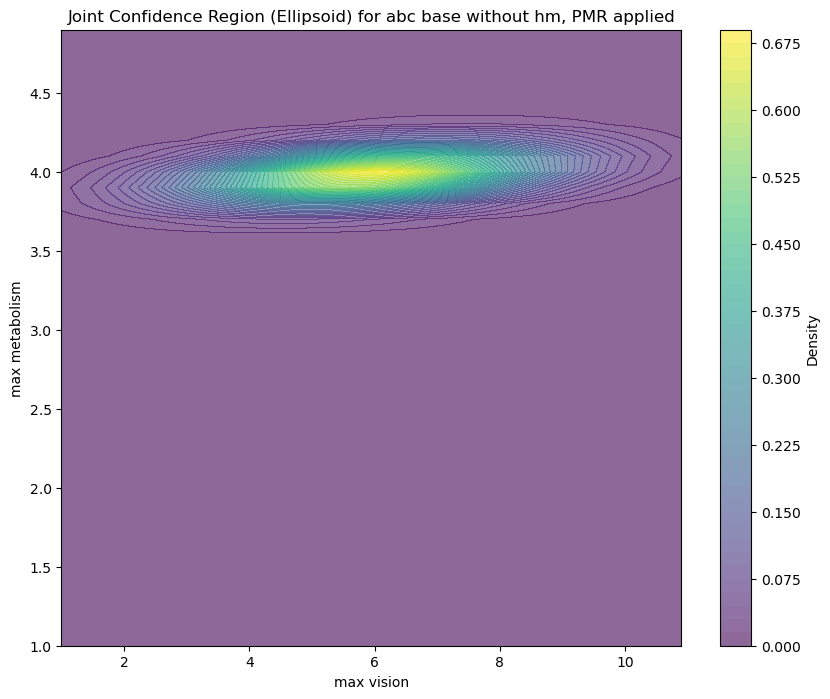

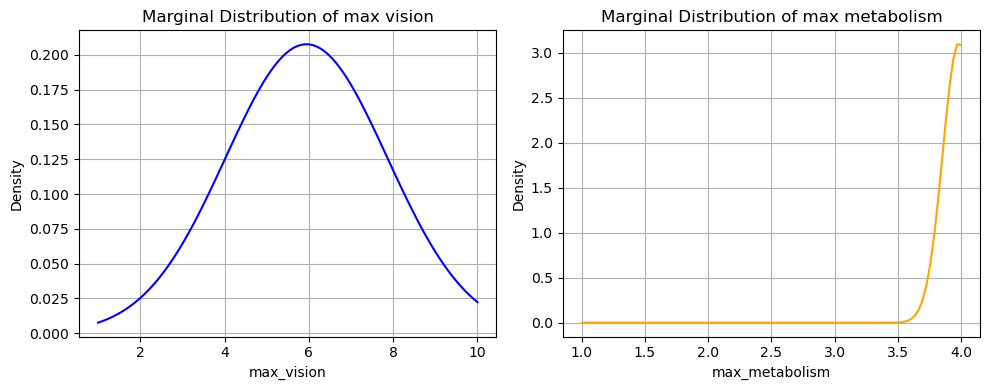

In [182]:
ciana1(data=pmr_data, keyword='abc base without hm, PMR applied')

## sa without hm: parameter estimates are discrete integer tuples

### initial_(1, 1)_obs_78_temp_10_coolrate_0.95 ---- satisfactory (4,6)

### initial (1,5): all four streams are not satif


In [193]:
sa_wout_history = np.load('E:/Imperial 2023-24/project!!/sugarscape/sim_annealing/SA_solution_history_iteration_500_initial_(1, 1)_obs_78_temp_10_coolrate_0.95.npy',
                          allow_pickle=True)
pd.Series(sa_wout_history).value_counts().sum()

501

Text(0.5, 1.0, '2D Histogram for Simulated Annealing with HM bot applied')

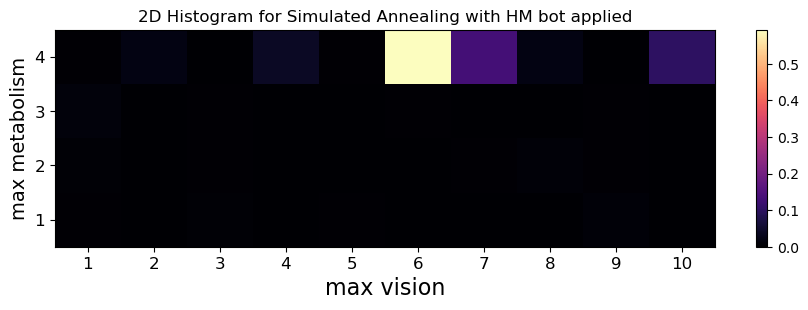

In [27]:
import matplotlib.pyplot as plt 
N =501
plot_results(sa_wout_history)
plt.title('2D Histogram for Simulated Annealing with HM bot applied')


The component wise CI for sa, without hm, is: 
 (array([3.79414177, 3.85855284]), array([6.00429534, 6.57853899]))
The joint ellipsoid CI for sa, without hm, is: 



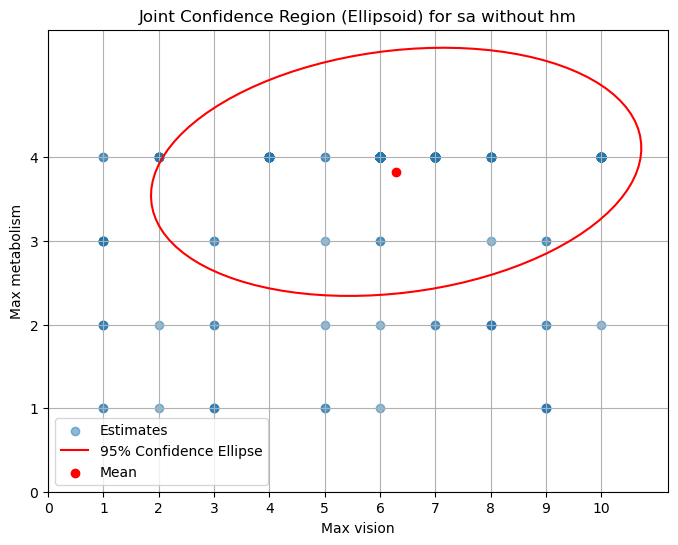

In [194]:
# ci analysis 
sa_wout_history = np.array([tuple(r) for r in sa_wout_history])
ci_ana = ciana(data=sa_wout_history, keyword='sa without hm')

print('The component wise CI for sa, without hm, is: \n',ci_ana.comp_wise_ci())
print('The joint ellipsoid CI for sa, without hm, is: \n')
ci_ana.joint_confi_ellipsoid()

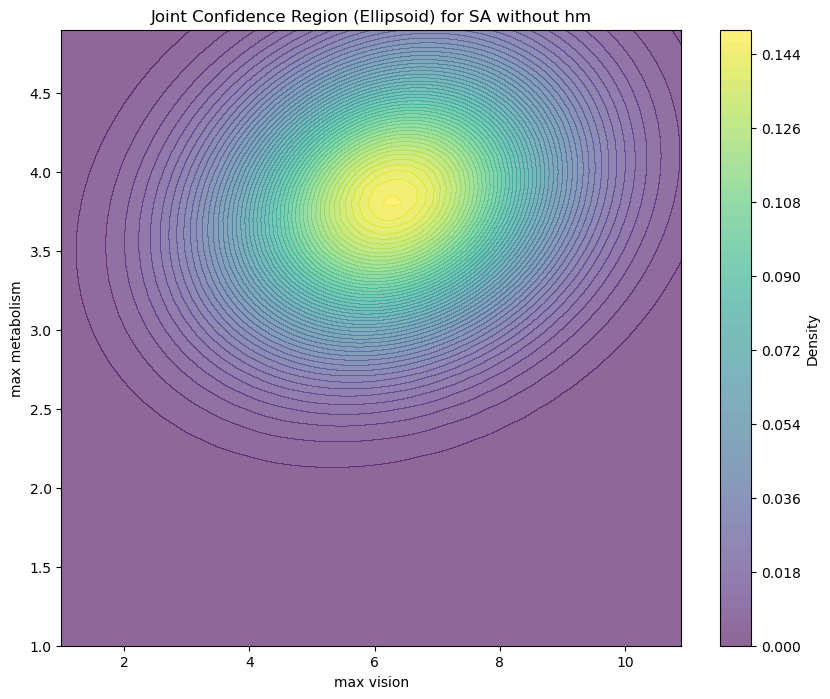

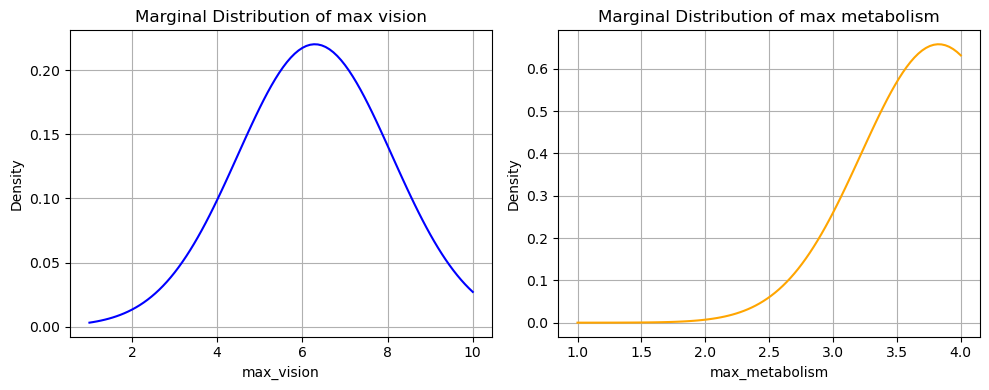

In [195]:
ciana1(data=sa_wout_history, keyword='SA without hm')

The other three stream are not densing in the nbhood of (4,6)

In [74]:
### initial_(1, 1)_obs_78_temp_10_coolrate_0.99 --- 

sa_wout_history = np.load('E:/Imperial 2023-24/project!!/sugarscape/sim_annealing/SA_solution_history_iteration_500_initial_(3, 2)_obs_78_temp_50_coolrate_0.95.npy',
                          allow_pickle=True)
pd.Series(sa_wout_history).value_counts()


[4, 3]     130
[4, 7]      71
[4, 9]      62
[4, 7]      46
[4, 8]      33
          ... 
[4, 10]      1
[1, 4]       1
[1, 3]       1
[1, 3]       1
[2, 8]       1
Name: count, Length: 71, dtype: int64

## smc_abc without hm

### gaussian kernel + adaptive

In [238]:
#### plot functions

xticks = range(0,12)
yticks = range(0,6)
def plot_results(keyword, weight=None, theta=None):
    fig, axes = plt.subplots(1, 1, figsize=(9, 3))
    # are weight necessary?
    N = len(theta)
    if weight==None:
        weight = [1 for i in range(N)]
    
    X = [t[1] for t in theta]
    Y = [t[0] for t in theta]
    p = plt.hist2d(x=X, y=Y, weights=weight, density=True,
                   bins=((xticks, yticks)), cmap='magma')
    plt.xlabel('max vision', fontsize=16)
    plt.ylabel('max metabolism', fontsize=14)
    plt.xticks([x for x in xticks[:-1]], xticks[:-1], fontsize=12)
    plt.yticks([y for y in yticks[:-1]], yticks[:-1], fontsize=12)
    plt.colorbar(p[3])
    plt.title(f'2D Histogram for the obtained set of parameter estimation by {keyword}')
    fig.tight_layout()

#### Alpha 0.5 + gaussian

In [196]:
############### 
#### smc_abc + adaptive + alpha = 0.5
eps_history = np.load('E:/Imperial 2023-24/project!!/sugarscape/abc_without_hm/smc_abc/uniform/eps_history_T_100_N_10_initial_eps_10_uniform_adapt_(True,)_alpha_0.5.npy', 
                      allow_pickle=True)
param_history = np.load('E:/Imperial 2023-24/project!!/sugarscape/abc_without_hm/smc_abc/uniform/noise_parameter_history_T_100_N_10_initial_eps_10_uniform_adapt_(True,)_alpha_0.5.npy', 
                      allow_pickle=True)
# print('param_history \n', param_history)
# print('eps_history \n', eps_history)
print('smc_abc, adaptive eps with alpha = 0.9, \n', param_history[-1,:])


smc_abc, adaptive eps with alpha = 0.9, 
 [array([[3.54744347],
        [2.03722302]]) array([[3.89982136],
                              [3.94808426]]) array([[3.6277767 ],
                                                    [7.22699355]])
 array([[3.78872237],
        [5.49873211]]) array([[3.52299367],
                              [4.61498004]]) array([[3.83862745],
                                                    [4.4521791 ]])
 array([[3.7599088 ],
        [6.76061932]]) array([[3.63599826],
                              [3.15281504]]) array([[3.88343167],
                                                    [9.90772656]])
 array([[3.5584664],
        [1.       ]])]


In [30]:
# the final estimate by smc-abc. alpha =0.5
param_history[-1,:]

array([array([3.65046128, 1.        ]), array([3.59387513, 6.03167151]),
       array([3.67011296, 4.15645981]), array([3.43347691, 2.53313993]),
       array([3.70068373, 1.80228392]), array([3.44257856, 2.3278009 ]),
       array([3.61227707, 1.        ]), array([3.63840431, 1.10735431]),
       array([3.41631307, 1.        ]), array([3.72227345, 7.12465558])],
      dtype=object)

In [197]:
# make sure the input array is 2-dim
param_history_reshaped = np.reshape(param_history, (1000,))


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (1000, 2) + inhomogeneous part.

In [198]:
import matplotlib.pyplot as plt 
N =1000
plot_results(param_history_reshaped[:,:])
plt.title('2D Histogram for SMC_abc with uniform kernel, alpha 0.5, HM bot applied')


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [199]:
# ci analysis 
keyword = 'smc_abc without hm, alpha=0.5'
ci_ana = ciana(data=param_history_reshaped[960:,:], keyword=keyword)

print(f'The component wise CI for {keyword} is: \n', ci_ana.comp_wise_ci())
print(f'The joint ellipsoid CI for {keyword}, is: \n')
ci_ana.joint_confi_ellipsoid()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

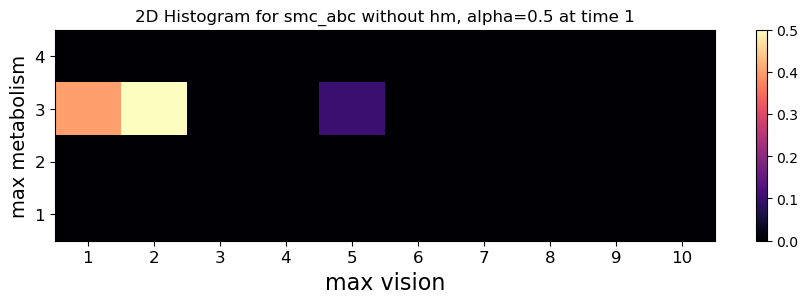

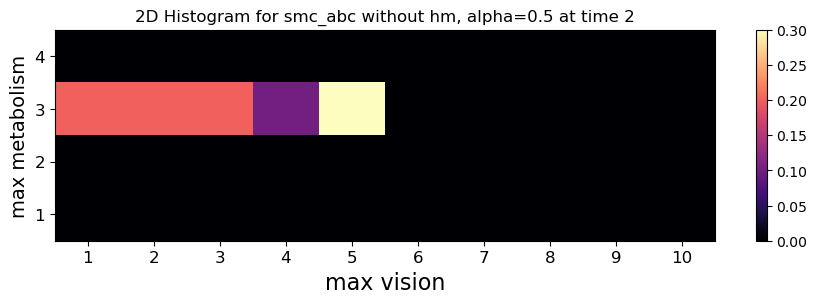

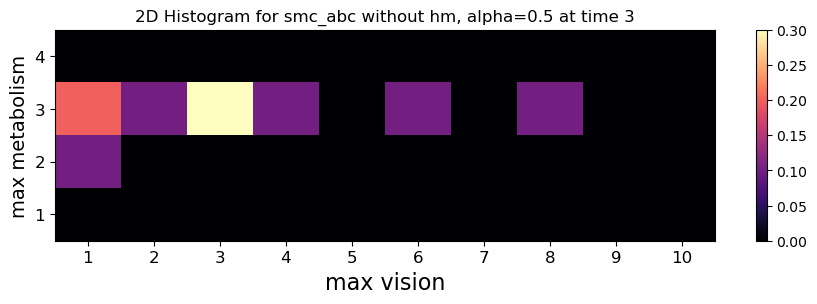

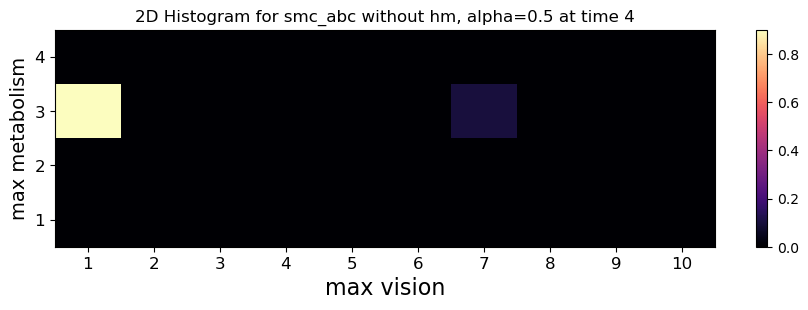

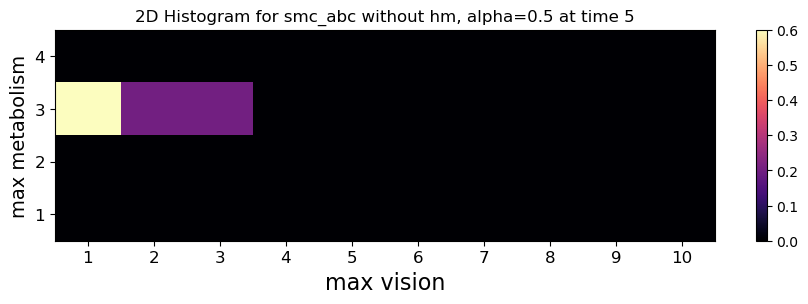

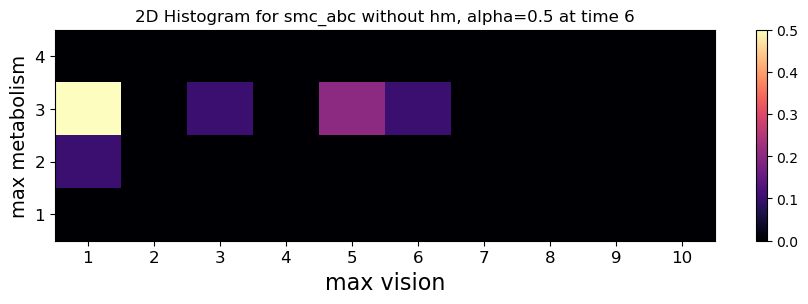

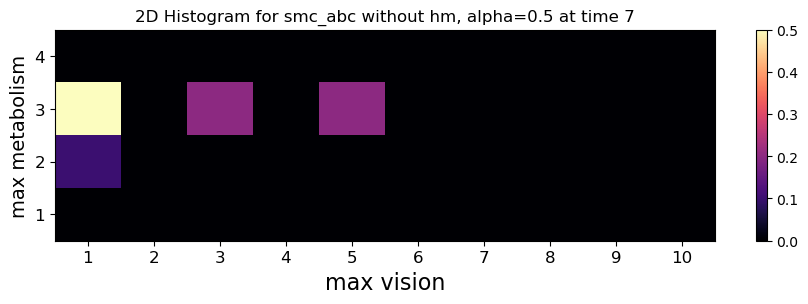

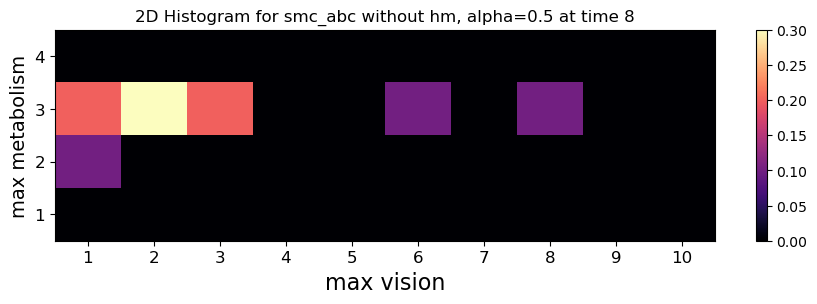

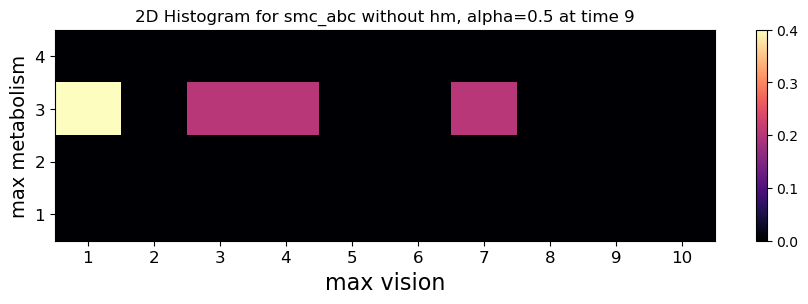

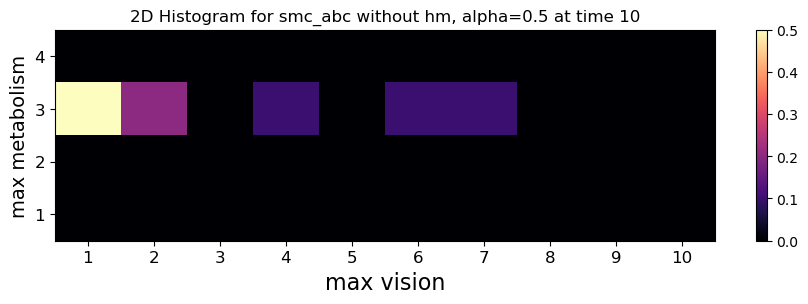

In [88]:
# print the snapshot of history

for t in range(1,11):
    plot_results(param_history[t*10-1,:])
    plt.title(f'2D Histogram for {keyword} at time {t}')

#### alpha 0.9 + gaussian

In [262]:
eps_history = np.load('E:/Imperial 2023-24/project!!/sugarscape/abc_without_hm/smc_abc/uniform/eps_history_T_100_N_10_initial_eps_10_uniform_adapt_(False,)_alpha_None.npy', 
                      allow_pickle=True)
param_history = np.load('E:/Imperial 2023-24/project!!/sugarscape/abc_without_hm/smc_abc/uniform/noise_parameter_history_T_100_N_10_initial_eps_10_uniform_adapt_(False,)_alpha_None.npy', 
                      allow_pickle=True)
param_history_reshaped = np.ndarray((1000,2))

i = 0
for r in param_history:
    for k in r:
        k = list(k)
        # if type(k[0])==np.array:
            # k = [k[0].item(), k[1].item()]
        param_history_reshaped[i,0], param_history_reshaped[i,1] =k[0].item(), k[1].item() 
        i += 1
param_history_reshaped


array([[3.579126  , 1.92080142],
       [3.79360645, 6.35107728],
       [3.70741249, 1.        ],
       ...,
       [3.95477149, 8.5759204 ],
       [3.62091935, 1.73006435],
       [3.94242477, 1.47919746]])

Text(0.5, 1.0, '2D Histogram for SMC_abc with uniform kernel, alpha 0.9, HM bot applied')

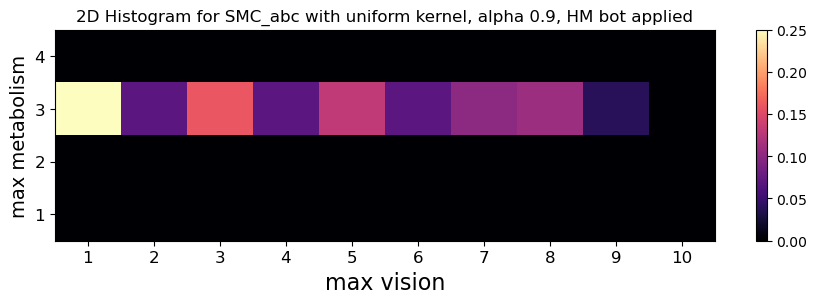

In [201]:
import matplotlib.pyplot as plt 
N =100
plot_results(param_history_reshaped[900:,:])
plt.title('2D Histogram for SMC_abc with uniform kernel, alpha 0.9, HM bot applied')


Text(0.5, 1.0, '2D Histogram for SMC_abc with gaussian kernel, alpha 0.9, HM bot applied')

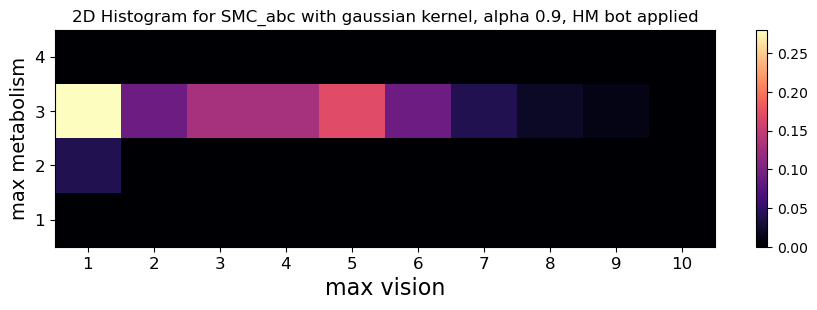

In [46]:
import matplotlib.pyplot as plt 
N =100
plot_results(param_history_reshaped[900:,:])
plt.title('2D Histogram for SMC_abc with gaussian kernel, alpha 0.9, HM bot applied')


In [77]:
weight_history = np.load('E:/Imperial 2023-24/project!!/sugarscape/abc_without_hm/smc_abc/obs78/adaptive/weight_history_T_100_N_10_initial_eps_10_gaussian_component_wise_adapt_(True,)_alpha_0.9.npy',
                         allow_pickle=True)
weight_history[-1,:] = weight_history[-1,:] / weight_history[-1,:].sum()
weight_history[-1,:]

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

remark: equal weight in the last step does not effectively distinguish any estimation from the other, therefore the final solution is not useful for inference, and we may need more iterations T. 

The component wise CI for smc_abc without hm, uniform kernel, alpha=None is: 
 (array([3.81359086, 3.83209969]), array([2.74390202, 7.35468708]))
The joint ellipsoid CI for smc_abc without hm, uniform kernel, alpha=None, is: 



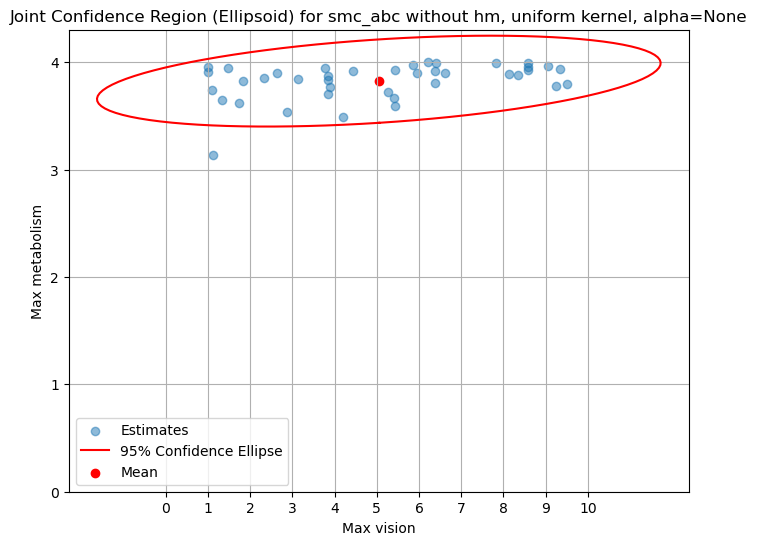

In [263]:
# ci analysis 
keyword = 'smc_abc without hm, uniform kernel, alpha=None'
ci_ana = ciana(data=param_history_reshaped[960:,:], keyword=keyword)

print(f'The component wise CI for {keyword} is: \n', ci_ana.comp_wise_ci())
print(f'The joint ellipsoid CI for {keyword}, is: \n')
ci_ana.joint_confi_ellipsoid()

## uniform

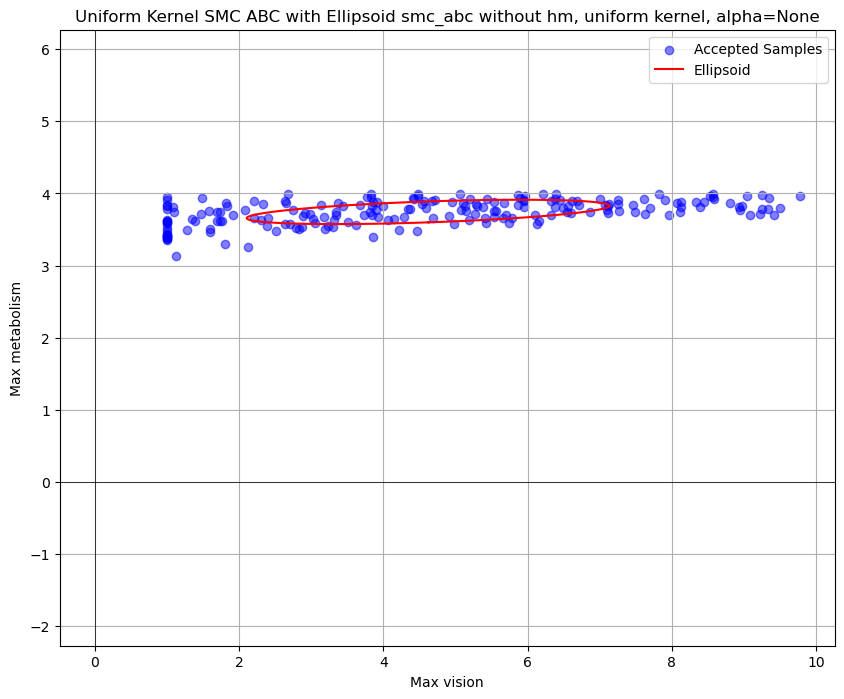

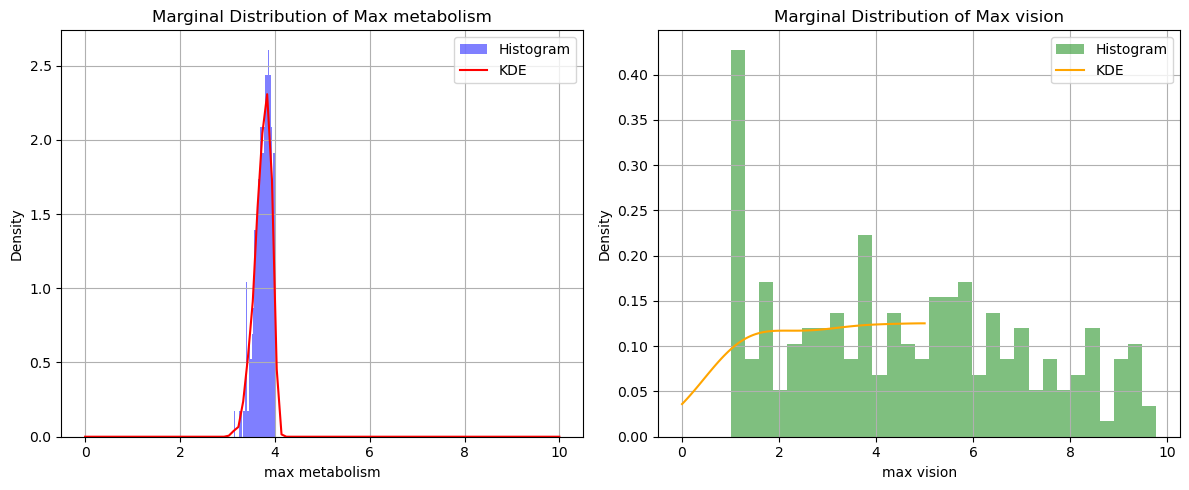

In [264]:
ciana2(data=param_history_reshaped[800:,:], keyword=keyword)

### non adaptive + gaussian

In [223]:
param_history = np.load('E:/Imperial 2023-24/project!!/sugarscape/abc_without_hm/smc_abc/gaussian/noadapt/parameter_history_T_100_N_10_initial_eps_10_gaussian_component_wise_adapt_(False,)_alpha_None.npy', 
                      allow_pickle=True)
param_history_reshaped = np.reshape(param_history, (1000,))
param_history_reshaped = np.array([ np.array(r) for r in param_history_reshaped]) # shape (1000,2)
print('smc_abc, non adaptive eps, \n', param_history[-1,:])


smc_abc, non adaptive eps, 
 [array([3.19697897, 2.01396764]) array([3.7397123, 4.8558694])
 array([3.87145501, 2.36079081]) array([3.19697897, 2.01396764])
 array([3.9463203 , 9.38769406]) array([3.87145501, 2.36079081])
 array([3.87145501, 2.36079081]) array([3.88565843, 5.90144355])
 array([3.19697897, 2.01396764]) array([3.59674703, 1.        ])]


Text(0.5, 1.0, '2D Histogram for SMC_abc with gaussian kernel, alpha=None, HM bot applied')

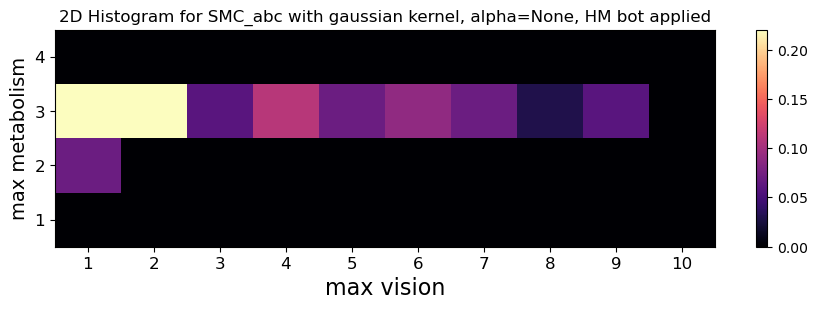

In [49]:
import matplotlib.pyplot as plt 
N =100
plot_results(param_history_reshaped[900:,:])
plt.title('2D Histogram for SMC_abc with gaussian kernel, alpha=None, HM bot applied')


In [62]:
weight_history = np.load('E:/Imperial 2023-24/project!!/sugarscape/abc_without_hm/smc_abc/obs78/noadapt/weight_history_T_100_N_10_initial_eps_10_gaussian_component_wise_adapt_(False,)_alpha_None.npy',
                         allow_pickle=True)
weight_history[-1,:] = weight_history[-1,:] / weight_history[-1,:].sum()
weight_history[-1,:]

array([0.07702101, 0.11159263, 0.11041355, 0.10506112, 0.07783798,
       0.11159263, 0.11037371, 0.10585722, 0.07865752, 0.11159263])

most ideal candidate: [3.88565843, 5.90144355] with prob/weight 0.10585722

The component wise CI for smc_abc without hm, gaussian kernel, no adaptive epsilon applied is: 
 (array([3.66486113, 3.70151618]), array([2.1230012 , 7.17474174]))
The joint ellipsoid CI for smc_abc without hm, gaussian kernel, no adaptive epsilon applied, is: 



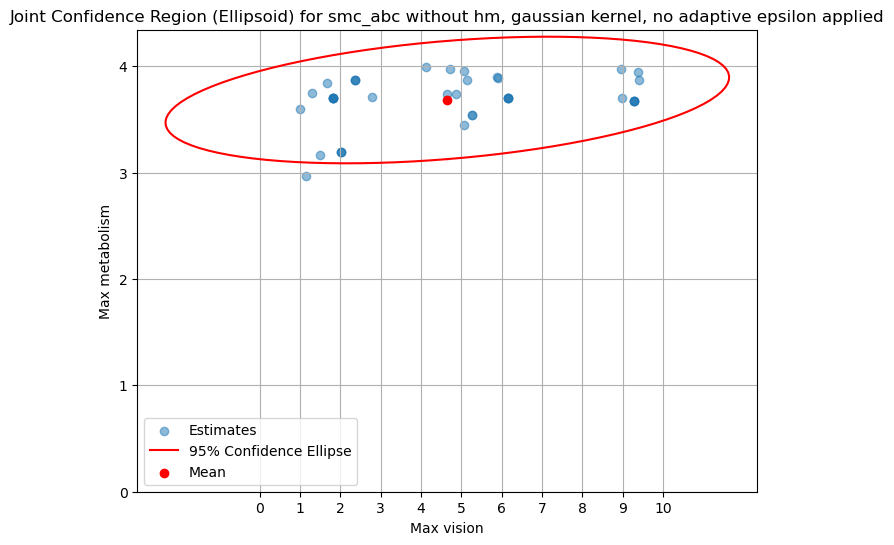

In [225]:
# ci analysis 
keyword = 'smc_abc without hm, gaussian kernel, no adaptive epsilon applied'
ci_ana = ciana(data=param_history_reshaped[960:,:], keyword=keyword)

print(f'The component wise CI for {keyword} is: \n', ci_ana.comp_wise_ci())
print(f'The joint ellipsoid CI for {keyword}, is: \n')
ci_ana.joint_confi_ellipsoid()

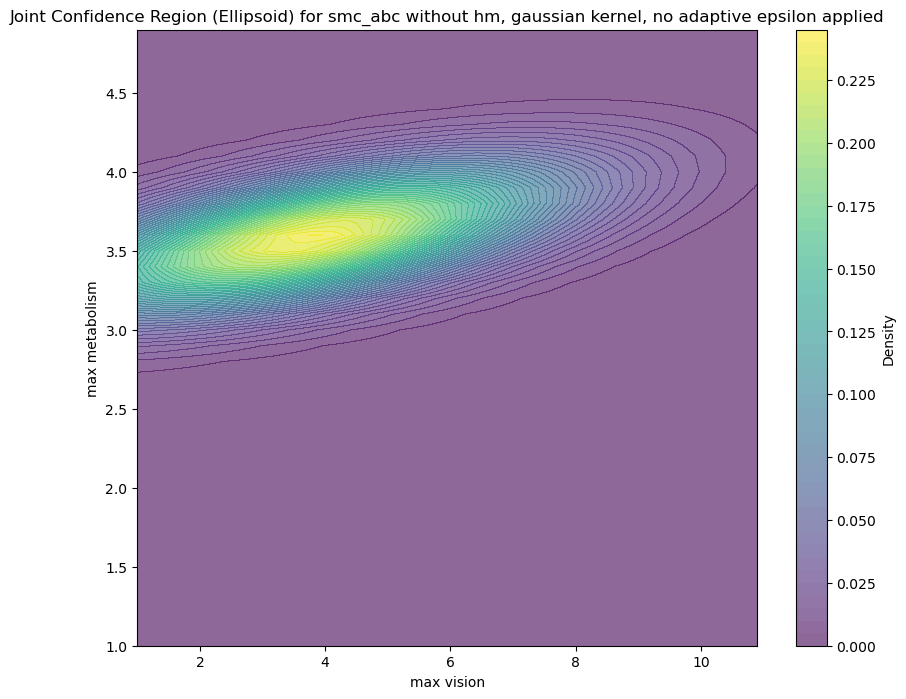

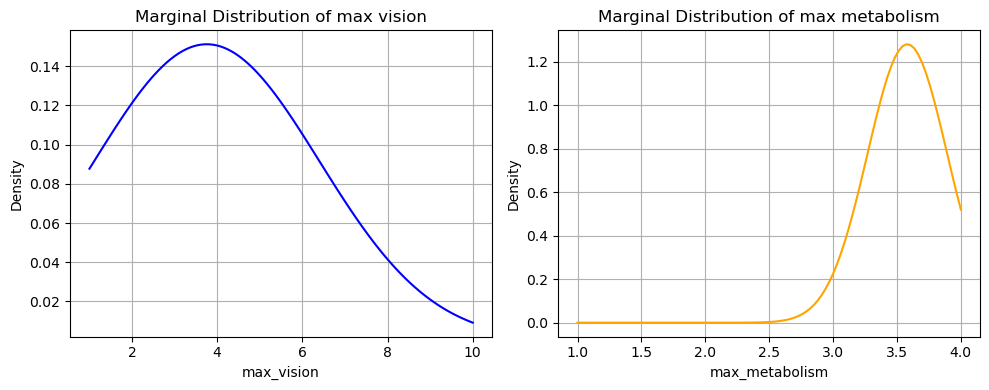

In [226]:

ciana1(data=param_history_reshaped[800:,:], keyword=keyword)

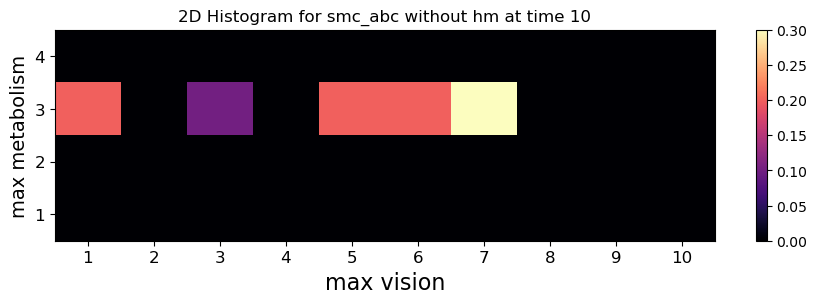

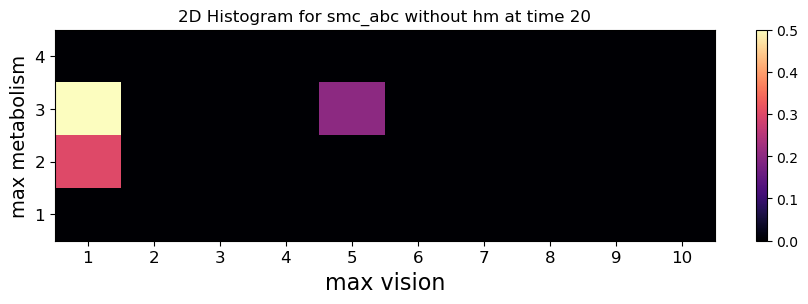

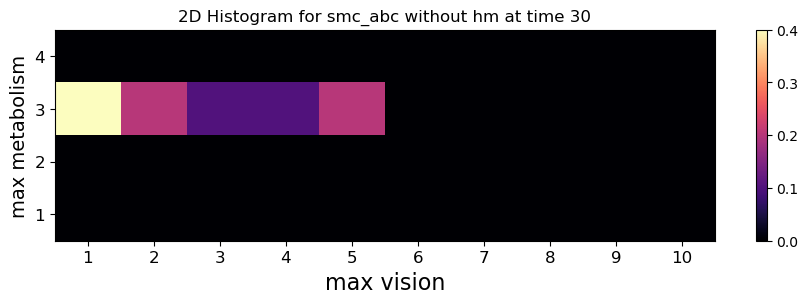

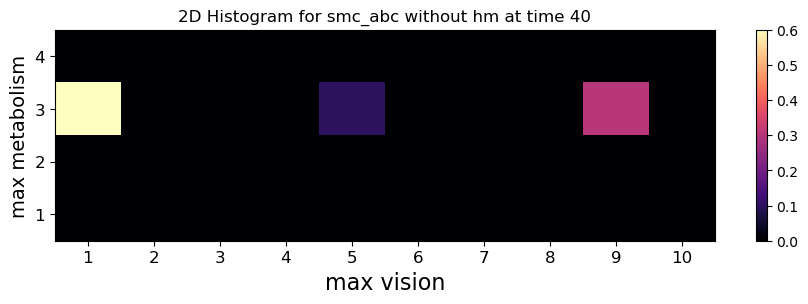

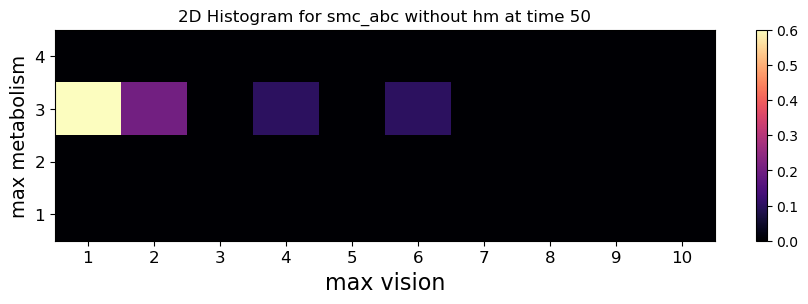

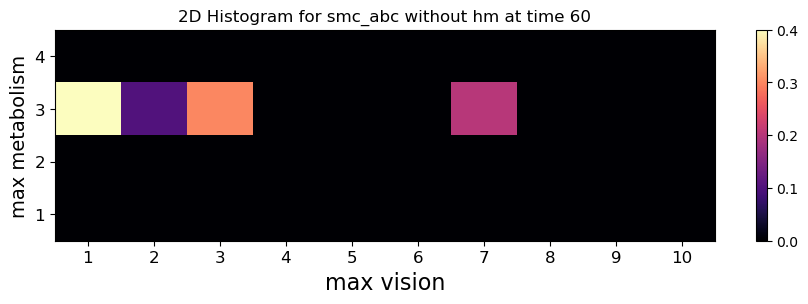

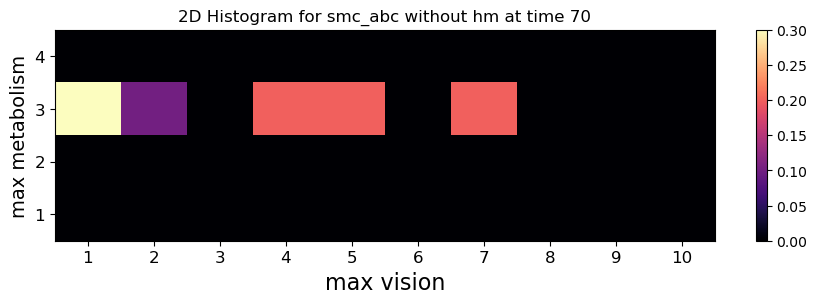

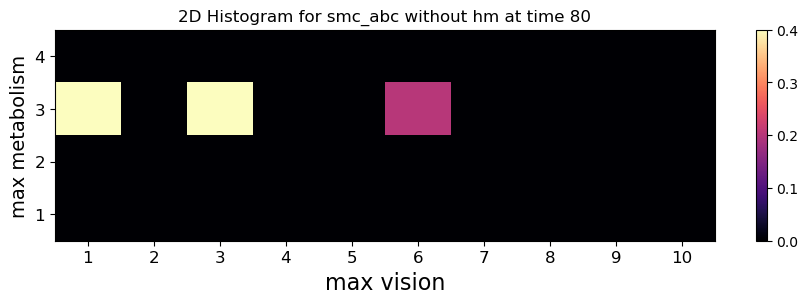

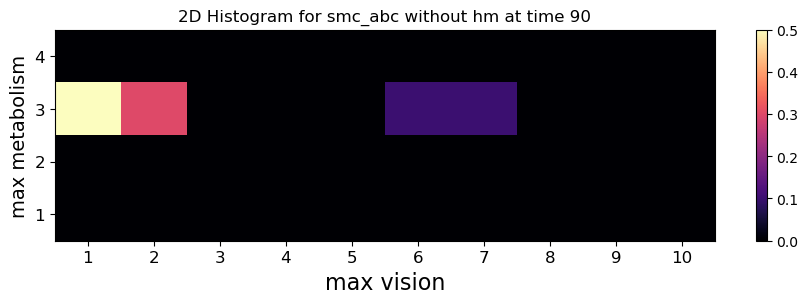

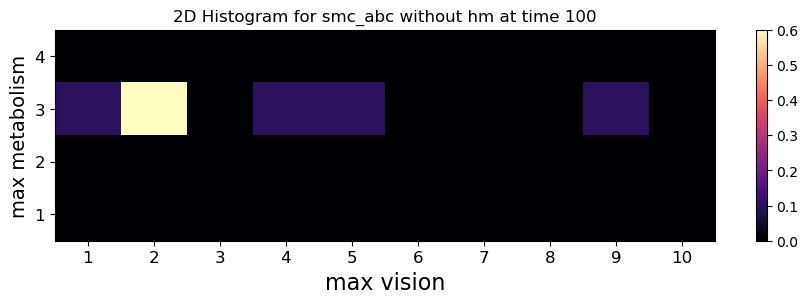

In [74]:
# print the snapshot of history

for t in range(1,11):
    plot_results(param_history[t*10-1,:])
    plt.title(f'2D Histogram for {keyword} at time {t*10}')

## block that will be repetitively used and referenced

In [ ]:
param_history = np.load('', 
                      allow_pickle=True)


weight_history[-1,:] = weight_history[-1,:] / weight_history[-1,:].sum()
weight_history[-1,:] = 

print('the last round ')
# reshape only applied to smc methods
param_history_reshaped = np.reshape(param_history, (1000,))
param_history_reshaped = np.array([ np.array(r) for r in param_history_reshaped]) # shape (1000,2)
print('smc_abc, non adaptive eps, \n', param_history[-1,:])

# ci analysis 
keyword = 'smc_abc without hm, uniform kernel, no adaptive epsilon applied'
ci_ana = ciana(data=param_history_reshaped[960:,:], keyword=keyword)

print(f'The component wise CI for {keyword} is: \n', ci_ana.comp_wise_ci())
print(f'The joint ellipsoid CI for {keyword}, is: \n')
ci_ana.joint_confi_ellipsoid()

### uniform + no adaptive

The component wise CI for smc_abc without hm, uniform kernel, no adaptive epsilon applied is: 
 (array([3.81359086, 3.83209969]), array([2.74390202, 7.35468708]))
The joint ellipsoid CI for smc_abc without hm, uniform kernel, no adaptive epsilon applied, is: 



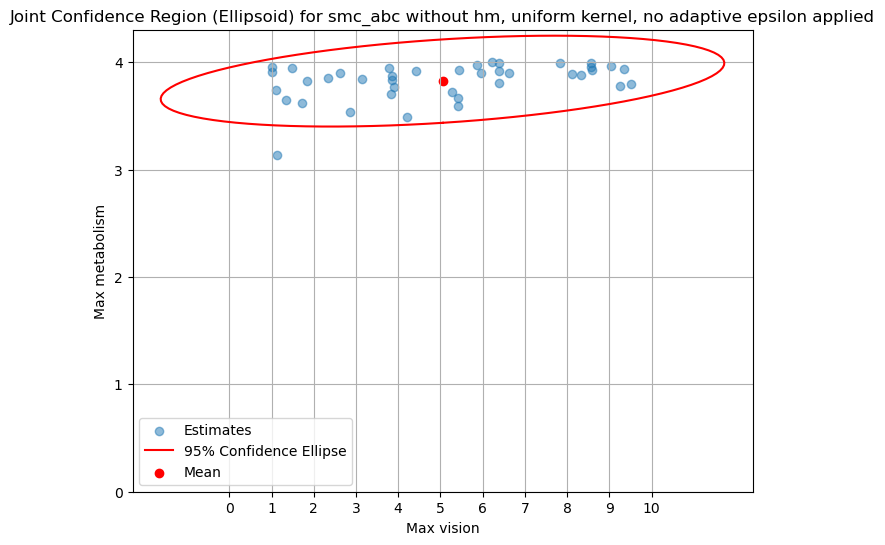

In [234]:
param_history = np.load('E:/Imperial 2023-24/project!!/sugarscape/abc_without_hm/smc_abc/uniform/noise_parameter_history_T_100_N_10_initial_eps_10_uniform_adapt_(False,)_alpha_None.npy', 
                      allow_pickle=True)
param_history_reshaped = np.ndarray((1000,2)) # shape (1000,2)

i= 0
for r in param_history:
    for k in r:
        k = list(k)
        if type(k[0])==np.ndarray:
            k = [k[0].item(), k[1].item()]
        param_history_reshaped[i,:] = k
        i += 1

# ci analysis 
keyword = 'smc_abc without hm, uniform kernel, no adaptive epsilon applied'
ci_ana = ciana(data=param_history_reshaped[960:,:], keyword=keyword)

print(f'The component wise CI for {keyword} is: \n', ci_ana.comp_wise_ci())
print(f'The joint ellipsoid CI for {keyword}, is: \n')
ci_ana.joint_confi_ellipsoid()

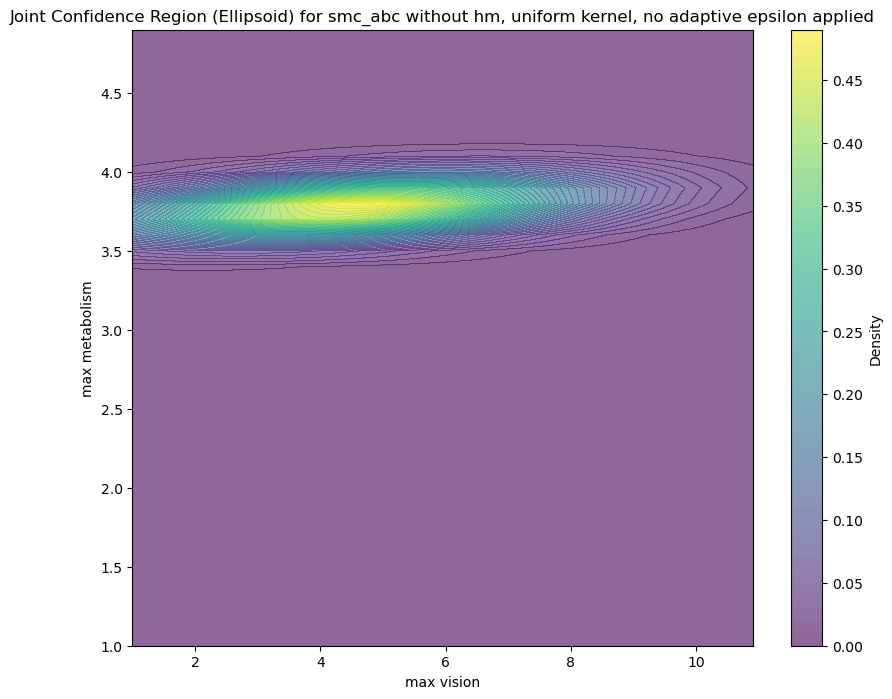

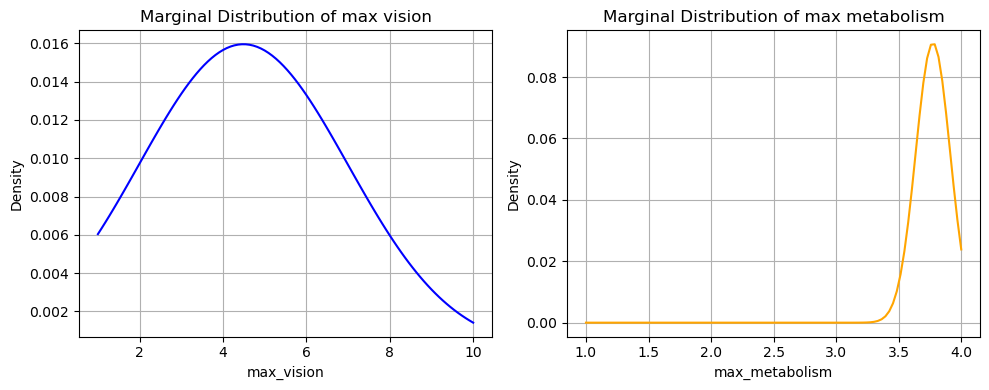

In [235]:
ciana1(param_history_reshaped, keyword=keyword)

### uniform + alpha=0.5

The component wise CI for smc_abc without hm, uniform kernel, adaptive epsilon applied with alpha=0.5 is: 
 (array([3.68320164, 3.69101458]), array([3.61186636, 5.98526234]))
The joint ellipsoid CI for smc_abc without hm, uniform kernel, adaptive epsilon applied with alpha=0.5, is: 



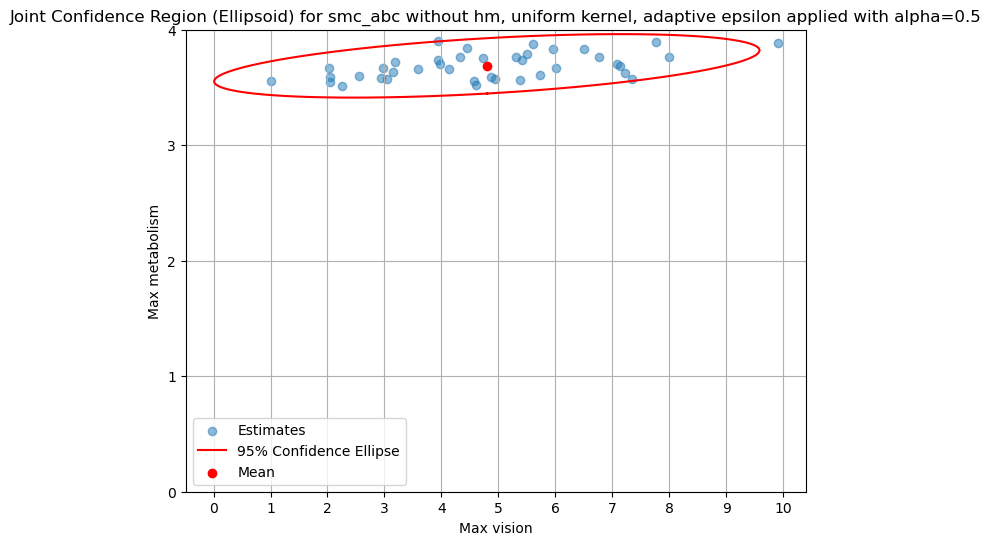

In [236]:
param_history = np.load('E:/Imperial 2023-24/project!!/sugarscape/abc_without_hm/smc_abc/uniform/noise_parameter_history_T_100_N_10_initial_eps_10_uniform_adapt_(True,)_alpha_0.5.npy', 
                      allow_pickle=True)
param_history_reshaped = np.ndarray((1000,2)) # shape (1000,2)

i= 0
for r in param_history:
    for k in r:
        k = list(k)
        if type(k[0])==np.ndarray:
            k = [k[0].item(), k[1].item()]
        param_history_reshaped[i,:] = k
        i += 1

# ci analysis 
keyword = 'smc_abc without hm, uniform kernel, adaptive epsilon applied with alpha=0.5'
ci_ana = ciana(data=param_history_reshaped[960:,:], keyword=keyword)

print(f'The component wise CI for {keyword} is: \n', ci_ana.comp_wise_ci())
print(f'The joint ellipsoid CI for {keyword}, is: \n')
ci_ana.joint_confi_ellipsoid()

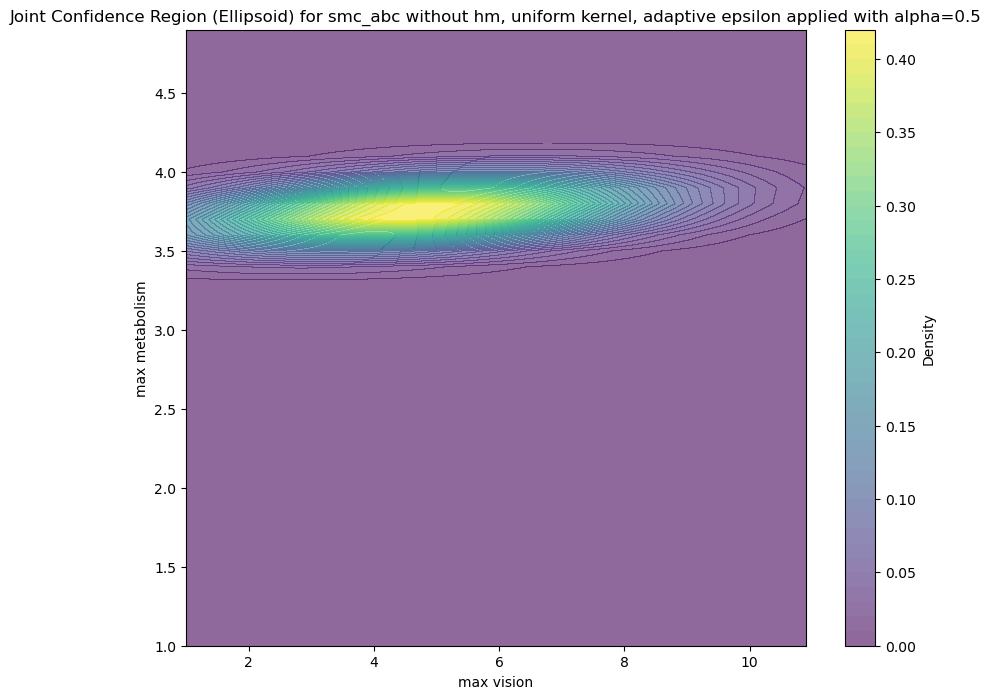

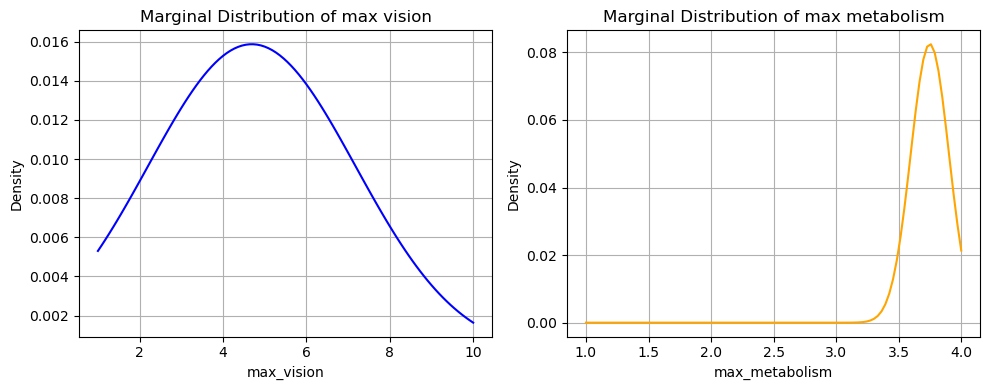

In [237]:
ciana1(param_history_reshaped, keyword)

### uniform alpha=0.9

The component wise CI for smc_abc without hm, uniform kernel, adaptive epsilon applied with alpha=0.9 is: 
 (array([3.67783757, 3.68505451]), array([2.34303374, 5.1309228 ]))
The joint ellipsoid CI for smc_abc without hm, uniform kernel, adaptive epsilon applied with alpha=0.9, is: 



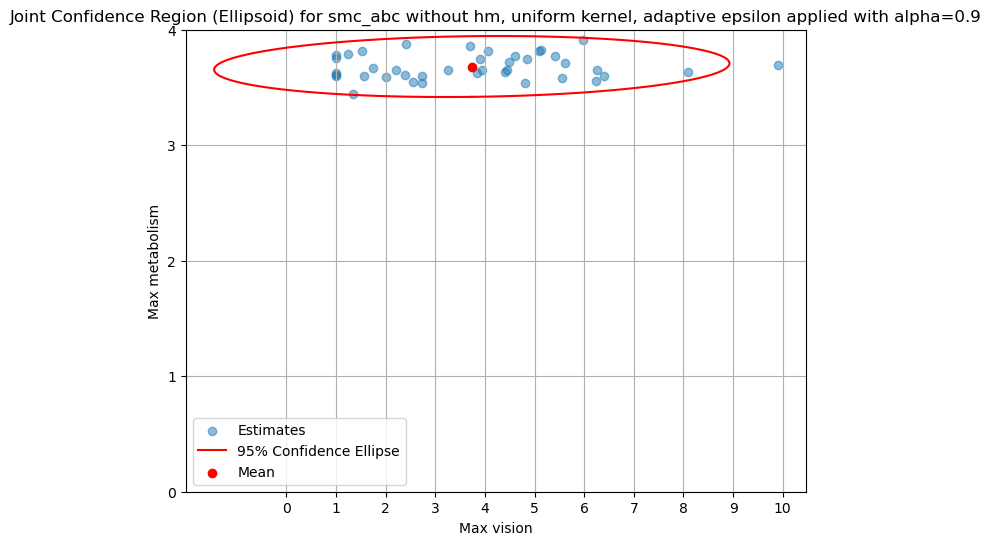

In [200]:
param_history = np.load('E:/Imperial 2023-24/project!!/sugarscape/abc_without_hm/smc_abc/uniform/noise_parameter_history_T_100_N_10_initial_eps_10_uniform_adapt_(True,)_alpha_0.9.npy', 
                      allow_pickle=True)
param_history_reshaped = np.ndarray((1000,2)) # shape (1000,2)

i= 0
for r in param_history: # map the np.array from shape (1000,) to (1000,2)
    for k in r:
        k = list(k)
        if type(k[0])==np.ndarray:
            k = [k[0].item(), k[1].item()]
        param_history_reshaped[i,:] = k
        i += 1

# ci analysis 
keyword = 'smc_abc without hm, uniform kernel, adaptive epsilon applied with alpha=0.9'
ci_ana = ciana(data=param_history_reshaped[960:,:], keyword=keyword)

print(f'The component wise CI for {keyword} is: \n', ci_ana.comp_wise_ci())
print(f'The joint ellipsoid CI for {keyword}, is: \n')
ci_ana.joint_confi_ellipsoid()

# abc with hm

## base abc + hm

In [17]:
import numpy as np
import pandas as pd
param_history = np.load('E:/Imperial 2023-24/project!!/sugarscape/abc_with_hm/rejabc/obs78/abc_reject_results_N=500_obs78_acceptance_threshold_10.npy',
                        allow_pickle=True)
param_history = np.array([r[0] for r in param_history if r[0][1]<=10]) # make sure it is 2-dim

param_history_tuple = [(param_history[r][0], param_history[r][1]) for r in range(300)]
pd.Series(param_history_tuple).value_counts()


(4, 10)    36
(4, 6)     34
(4, 5)     33
(4, 3)     33
(4, 4)     32
(4, 7)     29
(4, 2)     28
(4, 8)     24
(3, 1)     24
(4, 9)     23
(4, 1)      4
Name: count, dtype: int64

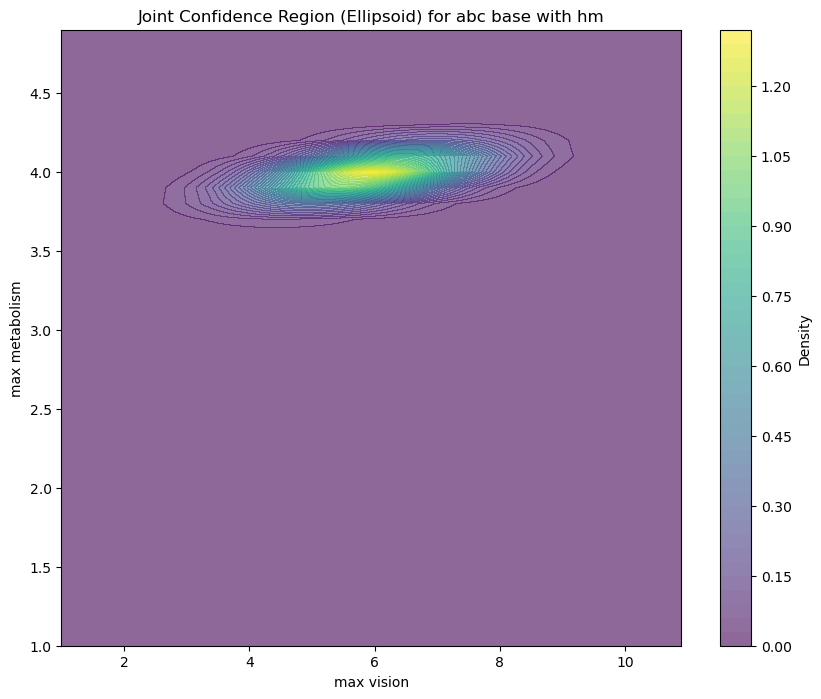

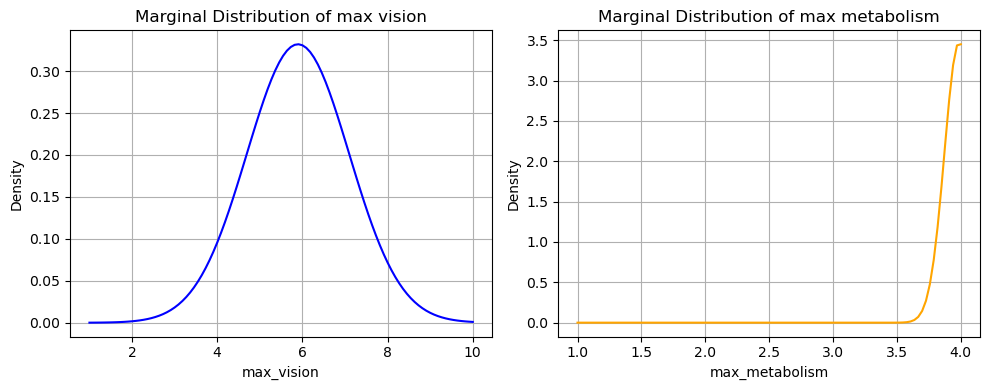

In [191]:
ciana1(data=param_history_tuple, keyword='abc base with hm')

In [20]:
import pickle
pmr_data = np.load('E:/Imperial 2023-24/project!!/sugarscape/pmr_with_abc.npy', allow_pickle=True) 


The component wise CI for abc with hm and PMR adjustment applied is: 
 (array([3.985173  , 3.98816034]), array([5.73324729, 6.06008604]))
The joint ellipsoid CI for abc with hm and PMR adjustment applied, is: 



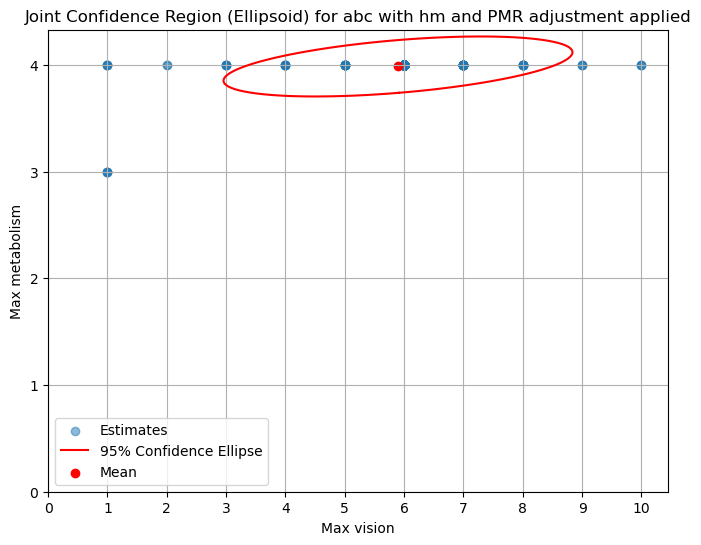

In [187]:
# ci analysis 
keyword = 'abc with hm and PMR adjustment applied'
ci_ana = ciana(data=pmr_data, keyword=keyword)

print(f'The component wise CI for {keyword} is: \n', ci_ana.comp_wise_ci())
print(f'The joint ellipsoid CI for {keyword}, is: \n')
ci_ana.joint_confi_ellipsoid()

Text(0.5, 1.0, 'Histogram for ABC base calibration, with HM, after PMR adjustemnt')

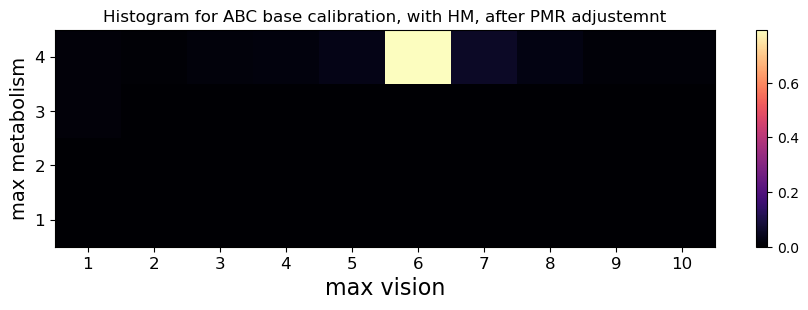

In [160]:
N= 300
plot_results(pmr_data)
plt.title('Histogram for ABC base calibration, with HM, after PMR adjustemnt')

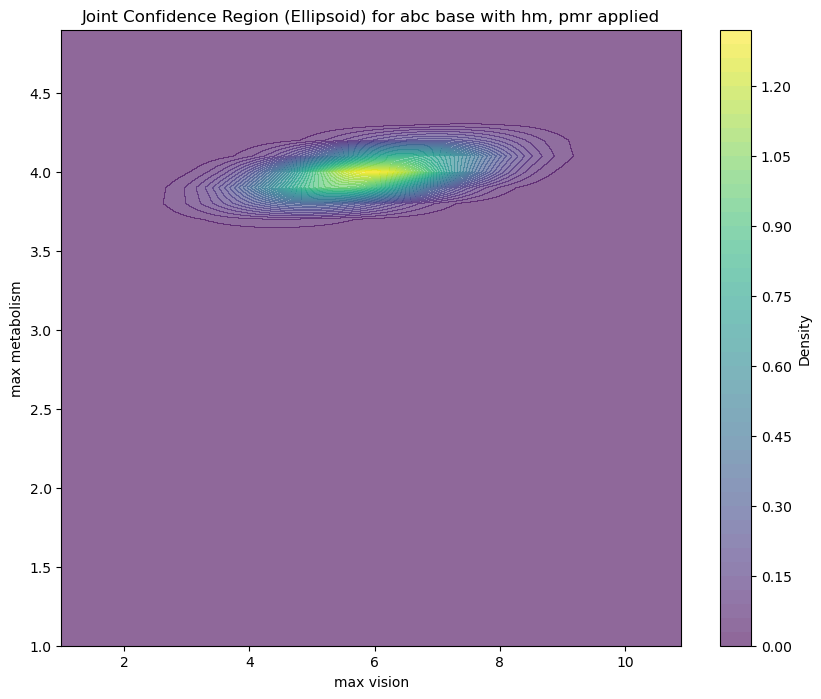

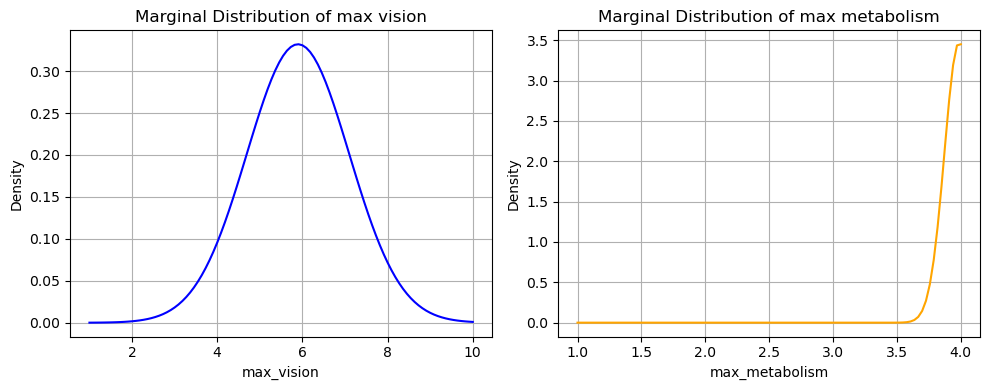

In [190]:
ciana1(data=pmr_data, keyword='abc base with hm, pmr applied')

Text(0.5, 1.0, '2D Histogram for ABC base with HM applied')

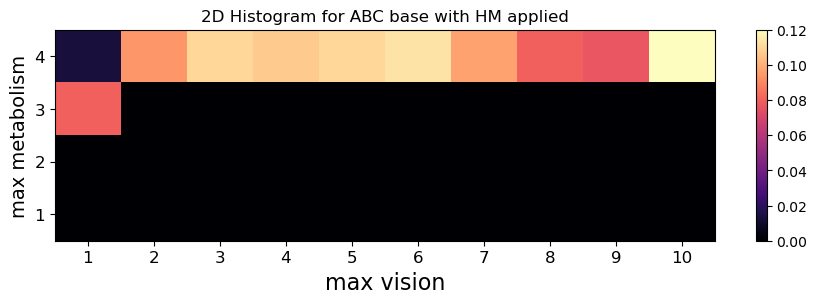

In [18]:
import matplotlib.pyplot as plt 
N =300
plot_results(param_history_tuple)
plt.title('2D Histogram for ABC base with HM applied')


The component wise CI for abc_base with hm, is: 
 (array([3.90608004, 3.92125809]), array([4.68922882, 6.217246  ]))
The joint ellipsoid CI for abc_base, with hm, is: 



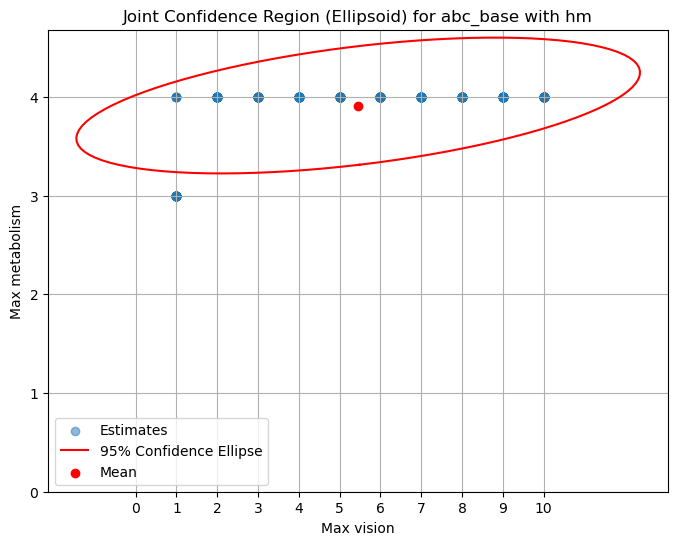

In [99]:
# credible interval analysis 
ci_ana = ciana(data=param_history, keyword='abc_base with hm')

print('The component wise CI for abc_base with hm, is: \n',ci_ana.comp_wise_ci())
print('The joint ellipsoid CI for abc_base, with hm, is: \n')
ci_ana.joint_confi_ellipsoid()


## smc_abc+hm

### smc_abc_hm + uniform + noadapt; any change to gaussian kernel or adaptive scheme will be changed based on the following code chunk

(1000, 2)
final obtained parameters: 
 [array([4.        , 4.62718251]) array([4.        , 3.01001471])
 array([4.       , 6.8711297]) array([4.        , 6.38656667])
 array([4.        , 4.48953072]) array([4.        , 3.96706396])
 array([4.        , 5.60927343]) array([4.        , 4.54124748])
 array([4.        , 4.99895806]) array([4.        , 3.73091673])]
The component wise CI for abc_base with hm, is: 
 (array([4., 4.]), array([5.18460411, 5.79027519]))
The joint ellipsoid CI for abc_base, with hm, is: 



D:\TEMP\ipykernel_152508\2199775322.py:31: RuntimeWarning: invalid value encountered in scalar divide
  self.corr = self.cov[0,1]/(self.theta1_std  * self.theta2_std)


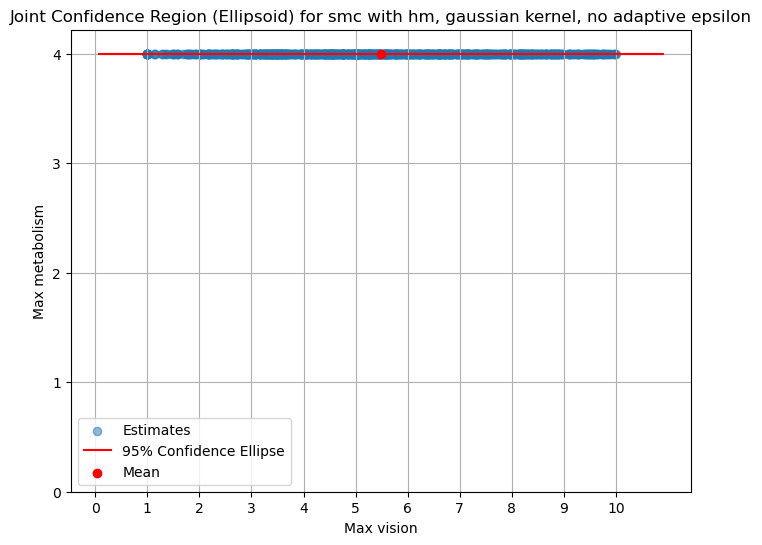

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

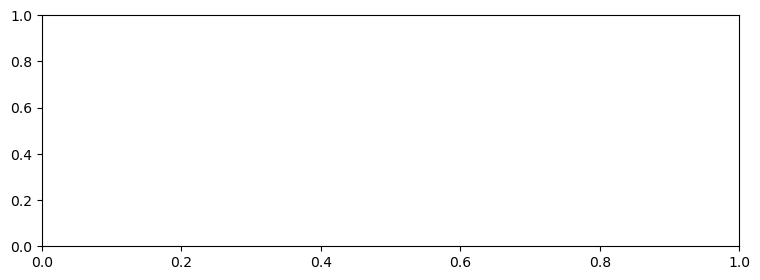

In [239]:
param_history = np.load('E:/Imperial 2023-24/project!!/sugarscape/smc_abc_with_hm/adapt/gaussian/noise_parameter_history_T_100_N_10_initial_eps_10_gaussian_adapt_(True,)_alpha_0.5.npy',
                        allow_pickle=True)
weight_history = np.load('E:/Imperial 2023-24/project!!/sugarscape/smc_abc_with_hm/adapt/gaussian/weight_history_T_100_N_10_initial_eps_10_gaussian_adapt_(True,)_alpha_0.5.npy',
                        allow_pickle=True)
param_history_reshaped = np.ndarray((1000,2)) # shape (1000,2)

i= 0
for r in param_history:
    for k in r:
        k = list(k)
        if type(k[0])==np.ndarray:
            k = [k[0].item(), k[1].item()]
        param_history_reshaped[i,:] = k
        i += 1
print(param_history_reshaped.shape)
print('final obtained parameters: \n', param_history[-1,:])

# ci analysis 
keyword = 'smc with hm, gaussian kernel, no adaptive epsilon'
ci_ana = ciana(data=param_history_reshaped, keyword=keyword)

print('The component wise CI for abc_base with hm, is: \n',ci_ana.comp_wise_ci())
print('The joint ellipsoid CI for abc_base, with hm, is: \n')
ci_ana.joint_confi_ellipsoid()

plot_results(keyword=keyword, theta= param_history[-1,:], weight=weight_history[-1,:])

In [237]:
param_history[-1,:]

array([array([4.        , 4.62718251]), array([4.        , 3.01001471]),
       array([4.       , 6.8711297]), array([4.        , 6.38656667]),
       array([4.        , 4.48953072]), array([4.        , 3.96706396]),
       array([4.        , 5.60927343]), array([4.        , 4.54124748]),
       array([4.        , 4.99895806]), array([4.        , 3.73091673])],
      dtype=object)

## sa + hm

(4,1) -> (4,9)



In [283]:
initial = [(4, 1), (4, 2), (4, 3), (4, 4), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10)]
best = (4,6)

import math
min_dis = math.inf

for tup in initial:
    # load the data
    param_history = np.load(f'E:/Imperial 2023-24/project!!/sugarscape/sim_annealing_hm/run2 iter=500/SA_solution_history_iteration_500_initial_{tup}_obs_78_temp_10_coolrate_0.99.npy',
                            allow_pickle=True)
    param_history = np.array(param_history)

    keyword = 'Simulated Annealing with HM'
    ci_ana = ciana(data=param_history, keyword=keyword)
    item = ci_ana.comp_wise_ci()
    if (item[0][0] >= 3.95) and (item[1][0] <= 6 <= item[1][1]):
        print(tup, item)
    # print('The component wise CI for abc_base with hm, is: \n',ci_ana.comp_wise_ci())
    # print('The joint ellipsoid CI for abc_base, with hm, is: \n')
    # ci_ana.joint_confi_ellipsoid()


(4, 2) (array([3.95671701, 3.96344267]), array([5.2814833 , 7.10574225]))
(4, 6) (array([3.96103273, 3.96711099]), array([5.17853045, 7.02506236]))
(4, 8) (array([3.95887452, 3.96527718]), array([4.87789722, 6.95443811]))
(4, 10) (array([3.9524041 , 3.95977155]), array([4.80285881, 6.98157233]))


## time analysis

### smc_abc_hm

In [121]:
time1 = np.load('E:/Imperial 2023-24/project!!/sugarscape/smc_abc_with_hm/adapt/gaussian/time_history_T_100_N_10_initial_eps_10_gaussian_adapt_(True,)_alpha_0.5.npy',
                allow_pickle=True)
time2 = np.load('E:/Imperial 2023-24/project!!/sugarscape/smc_abc_with_hm/adapt/gaussian/time_history_T_100_N_10_initial_eps_10_gaussian_adapt_(True,)_alpha_0.9.npy',
                allow_pickle=True)
time3 = np.load('E:/Imperial 2023-24/project!!/sugarscape/smc_abc_with_hm/adapt/uniform/time_history_T_100_N_10_initial_eps_10_uniform_adapt_(True,)_alpha_0.5.npy',
                allow_pickle=True)
time4 = np.load('E:/Imperial 2023-24/project!!/sugarscape/smc_abc_with_hm/adapt/uniform/time_history_T_100_N_10_initial_eps_10_uniform_adapt_(True,)_alpha_0.9.npy',
                allow_pickle=True)
time5 = np.load('E:/Imperial 2023-24/project!!/sugarscape/smc_abc_with_hm/noada/time_history_T_100_N_10_initial_eps_10_gaussian_adapt_(False,)_alpha_None.npy',
                allow_pickle=True)
time6 = np.load('E:/Imperial 2023-24/project!!/sugarscape/smc_abc_with_hm/noada/time_history_T_100_N_10_initial_eps_10_uniform_adapt_(False,)_alpha_None.npy',
                allow_pickle=True)
time6.mean()

0.6441365523338318

### smc_abc_without_hm

In [130]:
time1 = np.load('E:/Imperial 2023-24/project!!/sugarscape/abc_without_hm/smc_abc/uniform/time_history_T_100_N_10_initial_eps_10_uniform_adapt_(True,)_alpha_0.5.npy',
                allow_pickle=True)
time2 = np.load('E:/Imperial 2023-24/project!!/sugarscape/abc_without_hm/smc_abc/uniform/time_history_T_100_N_10_initial_eps_10_uniform_adapt_(True,)_alpha_0.9.npy',
                allow_pickle=True)
time3 = np.load('E:/Imperial 2023-24/project!!/sugarscape/abc_without_hm/smc_abc/uniform/time_history_T_100_N_10_initial_eps_10_uniform_adapt_(False,)_alpha_None.npy',
                allow_pickle=True)
time4 = np.load('E:/Imperial 2023-24/project!!/sugarscape/abc_without_hm/smc_abc/gaussian/adaptive/time_history_T_100_N_10_initial_eps_10_gaussian_component_wise_adapt_(True,)_alpha_0.5.npy',
                allow_pickle=True)
time5 = np.load('E:/Imperial 2023-24/project!!/sugarscape/abc_without_hm/smc_abc/gaussian/adaptive/time_history_T_100_N_10_initial_eps_10_gaussian_component_wise_adapt_(True,)_alpha_0.9.npy',
                allow_pickle=True)
time6 = np.load('E:/Imperial 2023-24/project!!/sugarscape/abc_without_hm/smc_abc/gaussian/noadapt/time_history_T_100_N_10_initial_eps_10_gaussian_component_wise_adapt_(False,)_alpha_None.npy',
                allow_pickle=True)
time6.mean()

37.98054373240471